# Desafio Descomplica

Abaixo temos o detalhamento do teste técnico. 
<br>Para realização de cada um, disponibilizamos tabelas com dados ficticios nas demais abas deste arquivo
<br>A expectativa é que seja entregue uma apresentação (Google Slides ou pdf) de como você apresentaria estes resultados analíticos
<br>É importante que mantenha os arquivos que usou no desenvolvimento da análise --> é possível que você seja questionado sobre a metodologia. Inclusive, em caso de apresentação, tendo de mostrar a sua linha de raciocinio!

**1- NPS**
<br>O Net Promoter Score é a métrica de lealdade de clientes mais difundida para serviços
<br>Na aba "Item 1" há uma pequena amostra de avaliação de alunos dos nossos cursos de vestibular
<br>Como você avaliaria estes dados? o que poderia tirar da pergunta aberta?

**2- Propensão**
<br>Gostariamos de prever alunos propensos à renovação de plano a partir de seu historico de interações com a plataforma
<br>Na aba "Item 2" há uma base de 1000 alunos com as interações em 1 semestre e uma flag em que 1 indica que houve renovação de plano
<br>Quais aprendizados você pode tirar do produto com esta análise? Como indicaria que se trabalhasse a propensão à renovação?

**3- Insights Mídia**
<br>Hoje temos um alto investimento em mídia online e isto define muito dos nossos acessos ao site e do nosso resultado de vendas
<br>Na aba "Item 3" há dados captados em 2 anos pelo Google Analytics
faça uma analise comparativa entre os anos e tire conclusões possíveis sobre as mídias que foram trabalhadas

### Carregando as Bibliotecas

In [17]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
from collections import Counter
from nltk.corpus import stopwords
from PIL import Image
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

### Importando os dados

In [18]:
dir_path = os.getcwd()

df1 = pd.read_excel(dir_path+'/TesteEspecialistaDataScience.xlsx', sheet_name='Item 1', encoding = 'ISO-8859-1')
df2 = pd.read_excel(dir_path+'/TesteEspecialistaDataScience.xlsx', sheet_name='Item 2', encoding = 'ISO-8859-1')
df3 = pd.read_excel(dir_path+'/TesteEspecialistaDataScience.xlsx', sheet_name='Item 3', encoding = 'ISO-8859-1')

In [19]:
def descricao_dados(df):
    print('='*80)
    print('='*5+' Dimensão da base de dados: {} colunas e {} registros.'.format(df.shape[1], df.shape[0]))
    print('='*80)
    print('='*5+' Colunas:')
    print(', \n'.join(['== '+x for x in df.columns.values]))
    print('='*80)
    print(df.info())
    print('='*80)

In [20]:
def aplicar_encode(i):
    try:
        x = i.encode('utf-8')
        return x
    except:
        return i

## 1- NPS
<br>O Net Promoter Score é a métrica de lealdade de clientes mais difundida para serviços
<br>Na aba "Item 1" há uma pequena amostra de avaliação de alunos dos nossos cursos de vestibular
<br>Como você avaliaria estes dados? o que poderia tirar da pergunta aberta?

### 1.1 Descrição dos dados

In [21]:
descricao_dados(df1)

===== Dimensão da base de dados: 3 colunas e 240 registros.
===== Colunas:
== id, 
== Qual é a probabilidade de você recomendar Descomplica a seus amigos e colegas?, 
== O que poderíamos fazer para melhorar?
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 3 columns):
id                                                                                240 non-null int64
Qual é a probabilidade de você recomendar Descomplica a seus amigos e colegas?    240 non-null int64
O que poderíamos fazer para melhorar?                                             49 non-null object
dtypes: int64(2), object(1)
memory usage: 5.8+ KB
None


### 1.2 Análise Exploratória dos Dados (EDA)

Alteração do nome das colunas para facilitar a análise

In [22]:
df1.columns = ['id', 'prob_recomendar', 'melhoria']

Verificando a frequência das avaliações dos alunos

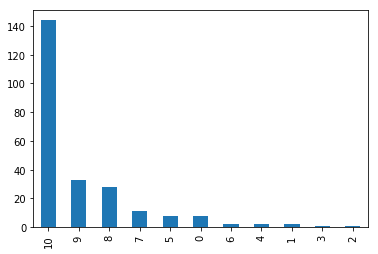

In [23]:
df1['prob_recomendar'].value_counts().plot(kind='bar')

In [47]:
df1['prob_recomendar'].value_counts()

10    144
9      33
8      28
7      11
5       8
0       8
6       2
4       2
1       2
3       1
2       1
Name: prob_recomendar, dtype: int64

In [24]:
df1['prob_recomendar'].value_counts(normalize = True)

10    0.600000
9     0.137500
8     0.116667
7     0.045833
5     0.033333
0     0.033333
6     0.008333
4     0.008333
1     0.008333
3     0.004167
2     0.004167
Name: prob_recomendar, dtype: float64

*É possível veriricar que 60% da base amostral avaliou o curso de vestibular com a nota máxima, ou seja, aproximadamente 2 a cada 3 alunos se mostraram totalmente satisfeitos com o curso.*

Criação de níveis de avaliação para análise dos comentários

In [25]:
# Definiação dos intervalos
bins = [-1,4,5,10]
# Aplicação dos intervalos e a criação de uma nova coluna no dataframe
df1['prob_nivel'] = pd.cut(df1['prob_recomendar'], bins, labels = ['baixo','medio','alto'])
df1['prob_nivel'].value_counts(normalize = True)

alto     0.908333
baixo    0.058333
medio    0.033333
Name: prob_nivel, dtype: float64

**Nível de avaliação x comentários realizados**

In [26]:
qtd_melhoria = df1['melhoria'].notnull().sum()
print('De {} registros da base amostral, {} ({:.2%}) dos alunos preencheram o campo de melhoria.'.
     format(df1.shape[0],
            qtd_melhoria,
            float(qtd_melhoria)/df1.shape[0]))

De 240 registros da base amostral, 49 (20.42%) dos alunos preencheram o campo de melhoria.


**Plotagem amostral dos comentários por nível de satisfação**

In [27]:
def print_nivel_melhoria(i):
    registro = df1.iloc[i]
    m = str(df1['melhoria'].iloc[i].encode('utf-8')[:60]) + '...'
    n = df1['prob_nivel'].iloc[i].encode('utf-8').upper()
    print('{} \t  :\t {}'.format(n,m))

In [28]:
print("Nivel NPS : \t Comentários melhorias\n")
for i in range(10):
    indice = df1[ (~df1['melhoria'].isna()) & (df1['prob_nivel'] == 'alto') ].sample(1).index[0]
    #print(indice)
    print_nivel_melhoria(indice)

Nivel NPS : 	 Comentários melhorias

b'ALTO' 	  :	 b'trocar o professor ao vivo de hist\xc3\xb3ria. #WillianGabriel'...
b'ALTO' 	  :	 b'Atualizar as aulas, bem como os materiais de apoio.'...
b'ALTO' 	  :	 b'Baixar as aulas estilo netflix'...
b'ALTO' 	  :	 b'renovar as aulas gravadas, usar quadro branco e utilizar de '...
b'ALTO' 	  :	 b'Amo'...
b'ALTO' 	  :	 b'mais cr\xc3\xa9ditos de reda\xc3\xa7\xc3\xa3o, dois por m\xc3\xaas \xc3\xa9 muito pouco, t'...
b'ALTO' 	  :	 b'diminuir os pre\xc3\xa7os'...
b'ALTO' 	  :	 b'colocar mais listas com exerc\xc3\xadcios'...
b'ALTO' 	  :	 b'ainda n\xc3\xa3o sei, n\xc3\xa3o comecei a us\xc3\xa1-lo'...
b'ALTO' 	  :	 b'explica detalhadamente cada deciplina para melhorar o rasioc'...


In [29]:
print("Nivel NPS : \t Comentários melhorias\n")
for i in range(10):
    indice = df1[ (~df1['melhoria'].isna()) & (df1['prob_nivel'] == 'baixo') ].sample(1).index[0]
    print_nivel_melhoria(indice)

Nivel NPS : 	 Comentários melhorias

b'BAIXO' 	  :	 b'uma porcaria'...
b'BAIXO' 	  :	 b'tudo'...
b'BAIXO' 	  :	 b'uma porcaria'...
b'BAIXO' 	  :	 b'tudo'...
b'BAIXO' 	  :	 b'uma porcaria'...
b'BAIXO' 	  :	 b'tudo'...
b'BAIXO' 	  :	 b'uma porcaria'...
b'BAIXO' 	  :	 b'uma porcaria'...
b'BAIXO' 	  :	 b'tudo'...
b'BAIXO' 	  :	 b'tudo'...


In [30]:
df1[ df1['prob_nivel'] == 'medio' ]['melhoria'].notnull().sum()

0

*Nenhuma avaliação de nível médio contém comentário para melhoria.*

**Análise da quantidade de palavras**

In [31]:
# Função para remoção de acentos nas palavras
from unicodedata import normalize
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

Criação dos dicionários pelos níveis de avaliação

In [33]:
contador_alto = Counter()
contador_baixo = Counter()
contador_total = Counter()

for i in df1[~df1['melhoria'].isna()].index:
    m = str(remover_acentos( df1['melhoria'].iloc[i] ).encode('utf-8').lower())
    n = df1['prob_nivel'].iloc[i]
    
    if n == 'alto':
        for w in nltk.word_tokenize(m):
                contador_alto[w] += 1
                contador_total[w] += 1
    elif n == 'baixo':
        for w in nltk.word_tokenize(m):
            contador_baixo[w] += 1
            contador_total[w] += 1
    else:
        pass

In [34]:
print('Total de palavras encontradas: {}.'.format(len(contador_total)))

Total de palavras encontradas: 328.


Palavras mais comuns no nível de satisfação baixo

In [35]:
contador_baixo.most_common()

[("'", 2), ("b'uma", 1), ('porcaria', 1), ("b'tudo", 1)]

*Encontrado apenas um comentário no nível de satisfação baixo.*

Palavras mais comuns de nível de satisfação alto

In [36]:
contador_alto.most_common()[:20]

[("'", 49),
 (',', 29),
 ('.', 22),
 ('de', 21),
 ('aulas', 16),
 ('e', 16),
 ('a', 12),
 ('!', 12),
 ('o', 12),
 ('as', 11),
 ('os', 11),
 ('mais', 9),
 ('com', 8),
 ('para', 8),
 ('que', 8),
 ('por', 7),
 ('nao', 6),
 ('das', 6),
 ('exercicios', 5),
 ('ser', 5)]

*Entre os elementos mais frequentes, foram encontrados muita pontuação e palavras que não possuem poder significativo. Será feita uma limpeza no dataset para eliminar esses casos.*

Limpeza do dataset removendo as stopwords e pontuação

In [37]:
for i in stopwords.words('portuguese'):
    del(contador_alto[i])
    del(contador_total[i])
    
lista_para_excluir = [',' , '.' , ';', ':', '!', '[', ']']
for i in lista_para_excluir:
    del(contador_alto[i])
    del(contador_total[i])
    
contador_alto.most_common()[:20]

[("'", 49),
 ('aulas', 16),
 ('nao', 6),
 ('exercicios', 5),
 ('ser', 5),
 ('redacao', 4),
 ('sao', 4),
 ('colocar', 3),
 ('tudo', 3),
 ('cada', 3),
 ('gravadas', 3),
 ("b'melhorar", 3),
 ('aplicativo', 3),
 ('excelente', 3),
 ('estudo', 3),
 ('estao', 3),
 ("b'acho", 2),
 ('videos', 2),
 ('redacoes', 2),
 ("b'poderia", 2)]

In [38]:
print('Total de palavras encontradas após a limpeza do dataset: {}.'.format(len(contador_total)))

Total de palavras encontradas após a limpeza do dataset: 284.


In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=40,relative_scaling=0.1,normalize_plurals=False).generate_from_frequencies(contador_total)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wc)

ModuleNotFoundError: No module named 'wordcloud'

*Verificar quais sao as sentenças com NÃO*

In [41]:
mask = np.array(Image.open("teste.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

# Transform your mask into a new one that will work with the function:
transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))

wc = WordCloud(background_color="white",width=2000,height=2000, max_words=100,relative_scaling=0.1,normalize_plurals=False, mask=transformed_mask, contour_width=1, contour_color='lightgray').generate_from_frequencies(contador_alto)
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wc)

NameError: name 'WordCloud' is not defined

In [51]:
for i in df1[~df1['melhoria'].isna()].index:
    if 'não' in df1['melhoria'].iloc[i]:
        print(df1['melhoria'].iloc[i])

ainda não sei, não comecei a usá-lo
Apenas uma sugestão: Colocar a opção de transmitir as aulas na TV, através do aplicativo do celular. Pelo menos as aulas gravadas, caso não seja possível ser feito com as ao vivo.
A única coisa que tenho a reclamar é que os créditos de redação não são acumulativos


In [52]:
for i in df1[~df1['melhoria'].isna()].index:
    if 'redação' in df1['melhoria'].iloc[i]:
        print(df1['melhoria'].iloc[i])

Melhorar o aplicativo. Colocar opção de redação no aplicativo :)
A única coisa que tenho a reclamar é que os créditos de redação não são acumulativos
mais créditos de redação, dois por mês é muito pouco, três seria o ideal;
correções mais criteriosas das redações;
aulas de redação para a unesp , conclusão sem proposta de intervenção


In [53]:
for i in df1[~df1['melhoria'].isna()].index:
    if 'aulas' in df1['melhoria'].iloc[i]:
        print(df1['melhoria'].iloc[i])

Acho importante colocar as datas das postagens das aulas.
renovar as aulas gravadas, usar quadro branco e utilizar de novas tecnologias como faz o biologia total
Atualizar as aulas, bem como os materiais de apoio.
Diminuir o tempo em algumas aulas, assim, sendo mais objetivo os assuntos. No restante, é um cursinho ótimo! <3
ter aulas presenciais
os videos quando aumento a velocidade ficam dessincronizado com o som.
as aulas do abner de química são maravilhosas, excelente prof!!!!
Baixar as aulas estilo netflix
Apenas uma sugestão: Colocar a opção de transmitir as aulas na TV, através do aplicativo do celular. Pelo menos as aulas gravadas, caso não seja possível ser feito com as ao vivo.
Acho que na seção disciplinas as aulas poderiam ser melhor organizadas. Por exemplo, em biologia e química muitas aulas estão repetidas. Normalmente, são os mesmos professores ministrando as mesmas aulas em dias diferentes. De resto acho o descomplica um curso excelente e muito democrático. Só tenho o q

## 2- Propensão
<br>Gostariamos de prever alunos propensos à renovação de plano a partir de seu historico de interações com a plataforma
<br>Na aba "Item 2" há uma base de 1000 alunos com as interações em 1 semestre e uma flag em que 1 indica que houve renovação de plano
<br>Quais aprendizados você pode tirar do produto com esta análise? Como indicaria que se trabalhasse a propensão à renovação?

### 2.1 Descrição dos dados

Renomear a coluna 'renovação' por 'renovacao'. Motivo: erro de decode

In [42]:
df2.rename( columns={df2.columns[-1]:remover_acentos( df2.columns[-1] )}, inplace=True )
df2['renovacao'] = df2['renovacao'].map({1:'sim', 0:'nao'})

In [43]:
df2.head()

,aluno_id,aula_online,aula_gravada,exercicios,simulados,renovacao
0,1,0,22,14.0,4,nao
1,2,1,49,24.0,0,nao
2,3,3,10,3.0,0,nao
3,4,7,13,6.0,3,nao
4,5,4,21,4.0,3,nao


In [44]:
descricao_dados(df2)

===== Dimensão da base de dados: 6 colunas e 999 registros.
===== Colunas:
== aluno_id, 
== aula_online, 
== aula_gravada, 
== exercicios, 
== simulados, 
== renovacao
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
aluno_id        999 non-null int64
aula_online     999 non-null int64
aula_gravada    999 non-null int64
exercicios      999 non-null float64
simulados       999 non-null int64
renovacao       999 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 47.0+ KB
None


In [45]:
print('De {} registros, {} ({:.2%}) dos alunos renovaram a assinatura e {} ({:.2%}) cancelaram.'
     .format(
         len(df2),
         df2['renovacao'].value_counts()['sim'],
         float(df2['renovacao'].value_counts()['sim']) / len(df2),
         df2['renovacao'].value_counts()['nao'],
         float(df2['renovacao'].value_counts()['nao']) / len(df2) ) )

De 999 registros, 145 (14.51%) dos alunos renovaram a assinatura e 854 (85.49%) cancelaram.


**Análise da distribuição dos dados a partir da renovação ou não da assinatura**

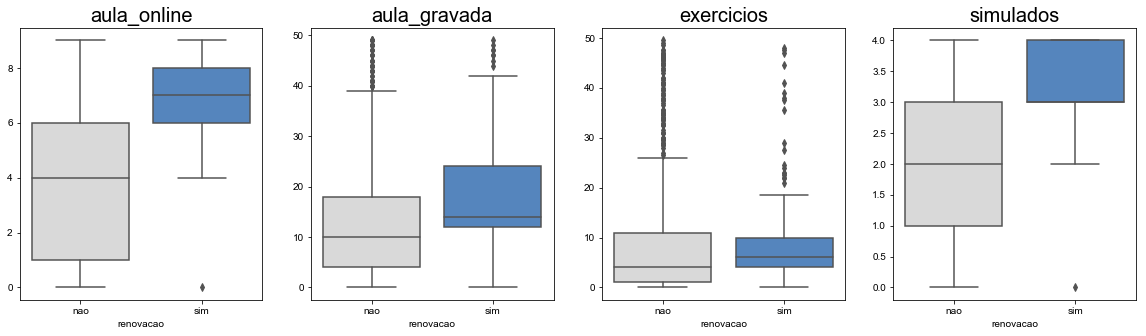

===== Dataset Renovação = "SIM" 
       aula_online  aula_gravada  exercicios   simulados
count   145.000000    145.000000  145.000000  145.000000
mean      7.048276     18.103448    9.579310    3.275862
std       1.696938     11.006768   10.378543    0.803489
min       0.000000      0.000000    0.000000    0.000000
25%       6.000000     12.000000    4.000000    3.000000
50%       7.000000     14.000000    6.000000    3.000000
75%       8.000000     24.000000   10.000000    4.000000
max       9.000000     49.000000   48.000000    4.000000
===== Dataset Renovação = "NÃO" 
       aula_online  aula_gravada  exercicios   simulados
count   854.000000    854.000000  854.000000  854.000000
mean      3.918033     13.163934    8.879391    1.823185
std       2.784201     12.017526   11.373164    1.371413
min       0.000000      0.000000    0.000000    0.000000
25%       1.000000      4.000000    1.000000    1.000000
50%       4.000000     10.000000    4.000000    2.000000
75%       6.000000    

In [46]:
%matplotlib inline
color_palette = ["#D9D9D9", "#4484CE"]

fig, axs = plt.subplots(ncols=4, figsize=(20,5))
sns.set(style="whitegrid")

for i, c in enumerate(df2.columns[1:]):
    if c != 'renovacao':
        sns.boxplot(x='renovacao', y=c, data=df2, palette=color_palette, ax=axs[i])
        axs[i].set_title(c, fontsize=20)
        axs[i].set_ylabel('')
        
plt.show()
print('='*60)
print('='*5 + ' Dataset Renovação = "SIM" ')
print('='*60)
print(df2[ df2['renovacao'] == 'sim'].describe().drop('aluno_id', axis=1) )
print('='*60)
print('='*5 + ' Dataset Renovação = "NÃO" ')
print('='*60)
print(df2[ df2['renovacao'] == 'nao'].describe().drop('aluno_id', axis=1) )

*Insights:*
- A maioria dos alunos que renovaram o curso tiveram um maior engajamento em aulas ao vivo do que os alunos que não renovaram, traduzindo em uma possível satisfação na qualidade das aulas ao vivo como também por ser um meio de comunicação dinâmico permite a interatividade dos alunos com os professores.
- Quanto às aulas gravadas, os alunos que renovaram sua assinatura tiveram um engajamento pouco acima dos alunos que não renovaram.
- No atributo de exercício demonstra que a dedicação à essa sessão não tem tanto poder decisório na renovação da assinatura. Ponto de melhoria.
- Já no atributo simulados, demonstra que a maioria dos alunos que renovaram a assinatura realizaram de 3 a 4 simulados.

**Análise de agrupamento**

In [54]:
X = df2.drop(columns=['aluno_id', 'renovacao'])
y = df2['renovacao']

In [55]:
kmeans = KMeans(n_clusters = 3, init = 'random', random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [56]:
distance = kmeans.fit_transform(X)
distance

array([[17.97587089, 24.11963468, 11.81211034],
       [45.86631971, 40.00082334, 20.66121852],
       [ 2.94594992, 31.80755277, 24.5594371 ],
       ...,
       [35.91391993, 32.86850461, 10.81836687],
       [10.91337774, 29.84097937, 16.04235213],
       [36.83248477, 33.74897244, 11.26061749]])

In [57]:
df2['predito'] = kmeans.labels_

In [58]:
df2.groupby(['predito', 'renovacao']).agg('count')['aluno_id']

predito  renovacao
0        nao          572
         sim           92
1        nao           98
         sim           12
2        nao          184
         sim           41
Name: aluno_id, dtype: int64

1 279767.2837837838
2 151011.12672021016
3 83800.31136439697
4 60791.101189387686
5 48258.99099157325
6 39645.106475909604
7 35575.928685822764
8 30441.867714451757
9 27698.75663833611
10 25863.42040861406


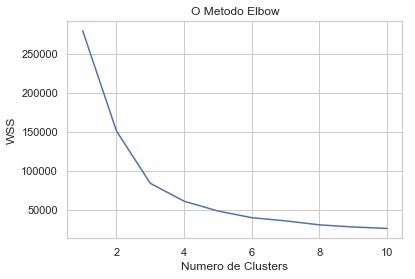

In [59]:
%matplotlib inline
wcss = []

for i in range(1, 11):
    kmeans2 = KMeans(n_clusters = i, init = 'random')
    kmeans2.fit(X)
    print (i,kmeans2.inertia_)
    wcss.append(kmeans2.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

In [60]:
kmeans3 = KMeans(n_clusters = 4, init = 'random', random_state=0)
kmeans3.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [61]:
df2['predito3'] = kmeans3.labels_

In [62]:
df2.groupby(['predito3', 'renovacao']).agg('count')['aluno_id']

predito3  renovacao
0         nao          430
          sim           43
1         nao           86
          sim           11
2         nao          103
          sim           24
3         nao          235
          sim           67
Name: aluno_id, dtype: int64

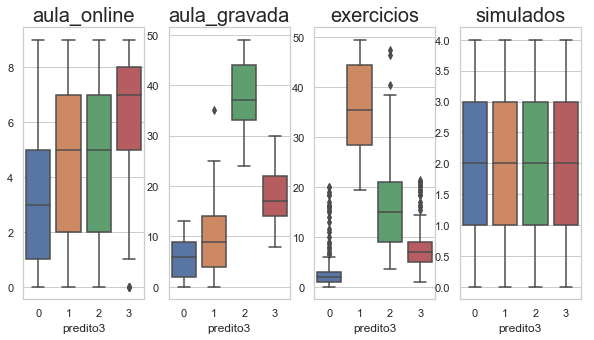

In [63]:
%matplotlib inline
teste = df2[ df2['predito3'] == 3 ]

fig, axs = plt.subplots(ncols=4, figsize=(10,5))
sns.set(style="whitegrid")

for i, c in enumerate(['aula_online', 'aula_gravada',  'exercicios', 'simulados']):
    if c != 'renovacao':
        sns.boxplot(x='predito3', y=c, data=df2, ax=axs[i])
        axs[i].set_title(c, fontsize=20)
        axs[i].set_ylabel('')

plt.show()

## 3- Insights Mídia
<br>Hoje temos um alto investimento em mídia online e isto define muito dos nossos acessos ao site e do nosso resultado de vendas
<br>Na aba "Item 3" há dados captados em 2 anos pelo Google Analytics faça uma analise comparativa entre os anos e tire conclusões possíveis sobre as mídias que foram trabalhadas

In [64]:
descricao_dados(df3)

===== Dimensão da base de dados: 8 colunas e 181 registros.
===== Colunas:
== Canal de Aquisição, 
== Month of Year, 
== Users, 
== New Users, 
== Sessions, 
== Bounce Rate, 
== Transactions, 
== Revenue
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 8 columns):
Canal de Aquisição    181 non-null object
Month of Year         181 non-null object
Users                 181 non-null int64
New Users             181 non-null int64
Sessions              181 non-null int64
Bounce Rate           181 non-null float64
Transactions          181 non-null int64
Revenue               181 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 11.4+ KB
None


In [65]:
df3.head()

,Canal de Aquisição,Month of Year,Users,New Users,Sessions,Bounce Rate,Transactions,Revenue
0,Busca Organica,Ano1Mes01,287952,110838,460391,0.0550,5499,1374998.91
1,Busca Organica,Ano1Mes02,216619,129798,420319,0.3259,3717,763378.74
2,Busca Organica,Ano1Mes03,56034,25518,67821,0.3468,2067,563614.36
3,Busca Organica,Ano1Mes04,1023648,653966,2167550,0.2456,7738,2107571.13
4,Busca Organica,Ano1Mes05,285563,144078,412557,0.2174,9453,2525933.32


A taxa de rejeição, ou **Bounce Rate**, é um número expresso em porcentagem e indica quantos visitantes acessaram uma única página do site de sua empresa e em seguida saíram, sem continuar a navegação em uma próxima página. Cada vez que isso acontece, é contabilizada uma rejeição.

**Tratamento dos dados**

In [66]:
novas_colunas=[]
for x in df3.columns:
    novas_colunas.append(remover_acentos(x).lower())

df3.rename( columns=dict(zip(df3.columns,novas_colunas )), inplace=True )

In [67]:
df3['month of year'].unique()

array(['Ano1Mes01', 'Ano1Mes02', 'Ano1Mes03', 'Ano1Mes04', 'Ano1Mes05',
       'Ano1Mes06', 'Ano1Mes07', 'Ano1Mes08', 'Ano1Mes09', 'Ano1Mes10',
       'Ano1Mes11', 'Ano1Mes12', 'Ano2Mes01', 'Ano2Mes02', 'Ano2Mes03',
       'Ano2Mes04', 'Ano2Mes05', 'Ano2Mes06', 'Ano2Mes07', 'Ano2Mes08',
       'Ano2Mes09', 'Ano2Mes10', 'Ano2Mes11', 'Ano2Mes12'], dtype=object)

In [68]:
# Criando colunas separadas para ano e mes
df3['ano'] = df3['month of year'].apply(lambda x: x[3])
df3['mes'] = df3['month of year'].apply(lambda x: x[-2:])

**Análise dos dados**

In [69]:
df3.head()

,canal de aquisicao,month of year,users,new users,sessions,bounce rate,transactions,revenue,ano,mes
0,Busca Organica,Ano1Mes01,287952,110838,460391,0.0550,5499,1374998.91,1,01
1,Busca Organica,Ano1Mes02,216619,129798,420319,0.3259,3717,763378.74,1,02
2,Busca Organica,Ano1Mes03,56034,25518,67821,0.3468,2067,563614.36,1,03
3,Busca Organica,Ano1Mes04,1023648,653966,2167550,0.2456,7738,2107571.13,1,04
4,Busca Organica,Ano1Mes05,285563,144078,412557,0.2174,9453,2525933.32,1,05


In [79]:
df3.groupby(['ano']).agg('sum').drop('bounce rate', axis=1)

,users,new users,sessions,transactions,revenue
ano,,,,,
1,10011975,6169270,23286252,69260,55947650.79
2,24123509,15786617,46657912,138263,34633451.53


In [70]:
df3.groupby(['canal de aquisicao']).agg('sum').drop('bounce rate', axis=1)

,users,new users,sessions,transactions,revenue
canal de aquisicao,,,,,
Busca Organica,16101859,9802689,31497366,83267,21103499.17
Direto,6081795,5248469,14004700,30806,14347072.79
Display,3291470,2155902,5605497,11563,2477057.97
Email Mkt,358042,137379,874620,1186,2592335.70
Facebook Ads,1760608,1264630,2546153,11322,2506180.60
Paid Search,1352848,754892,3627182,37292,40139201.53
Rede de Afiliados,3347920,1821144,5987374,15169,3479212.84
Referral,1782264,731912,5719781,16387,3804525.90
Youtube,58678,38870,81491,531,132015.82


In [81]:
df3.groupby(['canal de aquisicao','ano']).agg('sum').drop('bounce rate', axis=1).reset_index()

,canal de aquisicao,ano,users,new users,sessions,transactions,revenue
0,Busca Organica,1,4014781,2088517,9208643,38715,9260848.05
1,Busca Organica,2,12087078,7714172,22288723,44552,11842651.12
2,Direto,1,2084009,1911634,4423326,5990,8330582.52
3,Direto,2,3997786,3336835,9581374,24816,6016490.27
4,Display,1,1247052,816999,2517652,5496,1150276.63
5,Display,2,2044418,1338903,3087845,6067,1326781.34
6,Email Mkt,1,233993,92580,587479,508,2417123.12
7,Email Mkt,2,124049,44799,287141,678,175212.58
8,Facebook Ads,1,705415,355585,1317241,2113,437388.54
9,Facebook Ads,2,1055193,909045,1228912,9209,2068792.06


In [84]:
df3.corr()

,users,new users,sessions,bounce rate,transactions,revenue
users,1.000000,0.983221,0.950876,-0.010687,0.228094,0.025871
new users,0.983221,1.000000,0.943658,0.005786,0.225737,0.026446
sessions,0.950876,0.943658,1.000000,-0.057119,0.344360,0.067309
bounce rate,-0.010687,0.005786,-0.057119,1.000000,-0.010137,-0.027563
transactions,0.228094,0.225737,0.344360,-0.010137,1.000000,0.325284
revenue,0.025871,0.026446,0.067309,-0.027563,0.325284,1.000000


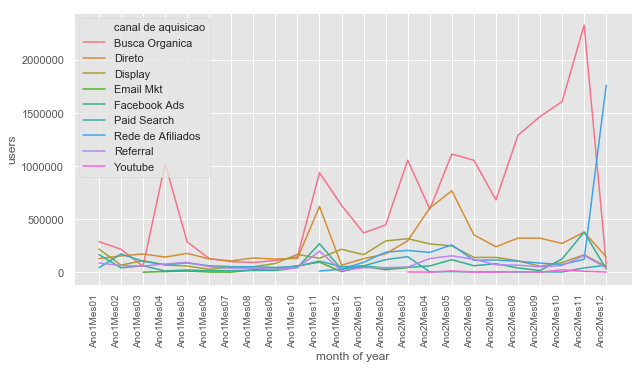

In [126]:
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='users', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

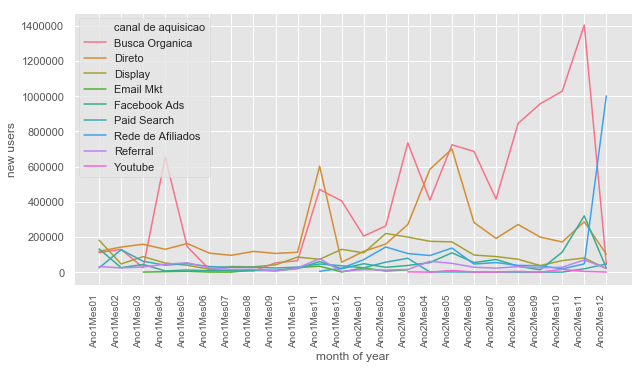

In [127]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='new users', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

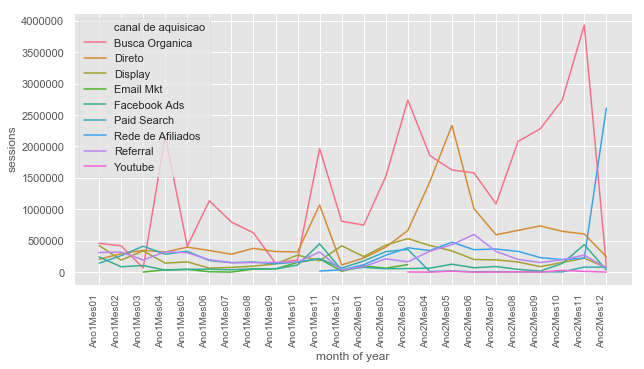

In [128]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='sessions', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

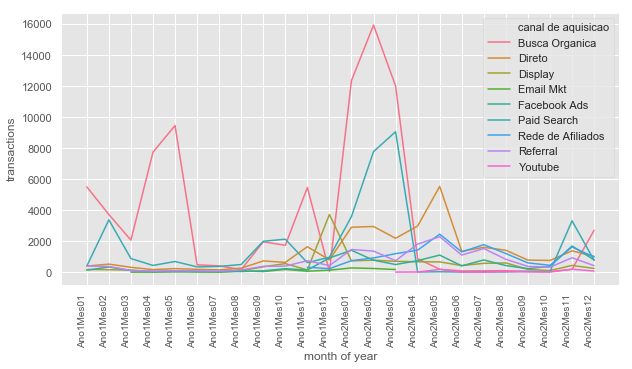

In [129]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='transactions', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

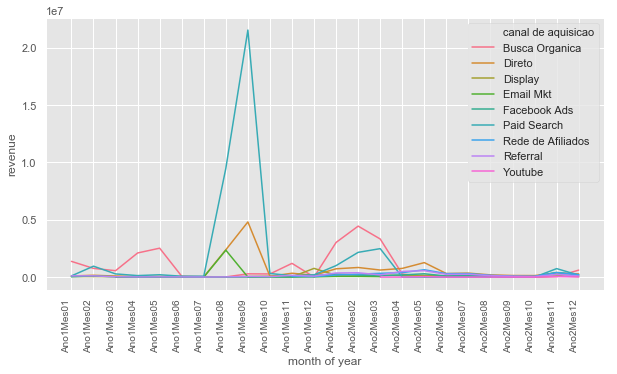

In [130]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='revenue', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

In [72]:
metricas_acum = ['users', 'new users', 'sessions', 'transactions', 'revenue']
lista_canais = list(df3['canal de aquisicao'].unique())

In [73]:
# Criação das colunas de soma móvel 6 meses
for c in metricas_acum:
    nome_col = c+'_sm6'
    df3[nome_col] = ''
    #print(nome_col)
    
    for x in lista_canais:
        #print(x)
        df3[nome_col].update( df3[ df3['canal de aquisicao'] == x][c].rolling(6).sum() )

In [117]:
df3.head()

,canal de aquisicao,month of year,users,new users,sessions,bounce rate,transactions,revenue,ano,mes,users_sm6,new users_sm6,sessions_sm6,transactions_sm6,revenue_sm6
0,Busca Organica,Ano1Mes01,287952,110838,460391,0.0550,5499,1374998.91,1,01,NaN,,,,
1,Busca Organica,Ano1Mes02,216619,129798,420319,0.3259,3717,763378.74,1,02,NaN,,,,
2,Busca Organica,Ano1Mes03,56034,25518,67821,0.3468,2067,563614.36,1,03,NaN,,,,
3,Busca Organica,Ano1Mes04,1023648,653966,2167550,0.2456,7738,2107571.13,1,04,NaN,,,,
4,Busca Organica,Ano1Mes05,285563,144078,412557,0.2174,9453,2525933.32,1,05,NaN,,,,


In [118]:
lista_sm6 = ['users_sm6','new users_sm6', 'sessions_sm6', 'transactions_sm6', 'revenue_sm6']

In [119]:
import numpy as np

for c in lista_sm6:
    lista_valores = []
    for i in df3[c]:
        try:
            n=int(i)
        except:
            n = np.nan
        finally:
            lista_valores.append(n)

    df3[c] = lista_valores

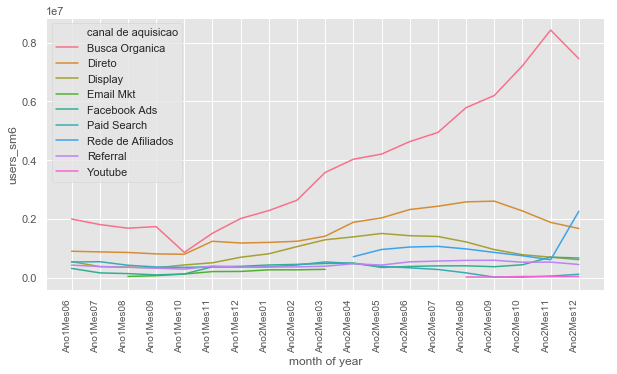

In [131]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='users_sm6', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

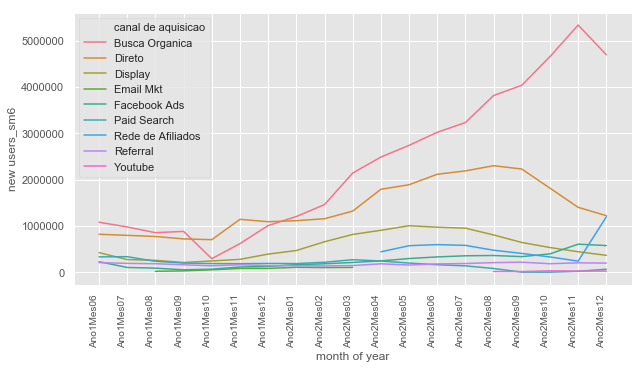

In [132]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='new users_sm6', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

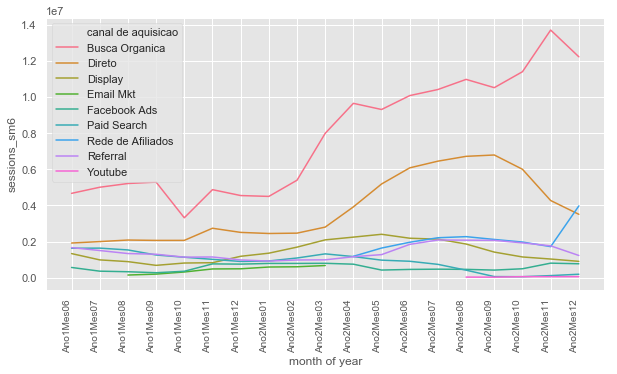

In [133]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='sessions_sm6', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

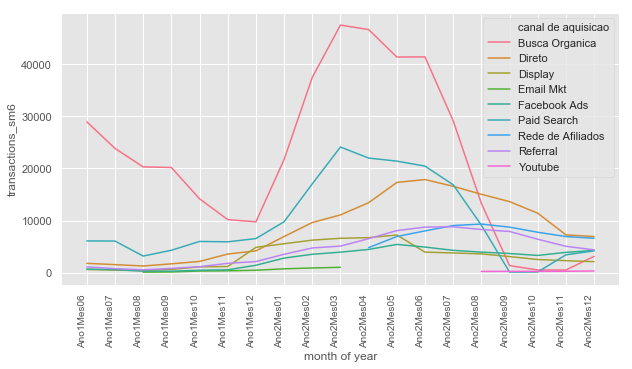

In [134]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='transactions_sm6', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

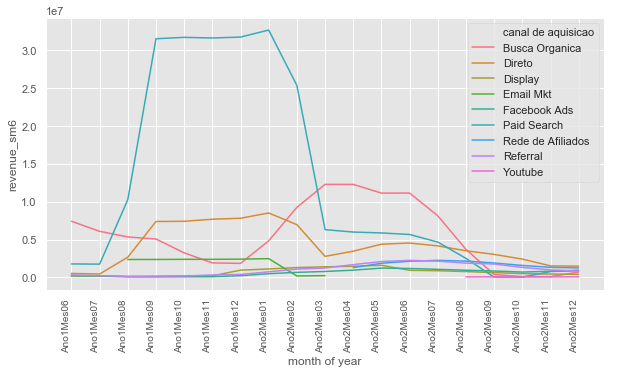

In [135]:
%matplotlib inline
plt.figure(figsize=(10,5))
chart = sns.lineplot(x='month of year', y='revenue_sm6', hue = 'canal de aquisicao', data=df3)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='10'  
)
plt.show()

In [75]:
# Agrupamento dos dados por total de ano
df3_total_ano = df3.groupby(['canal de aquisicao', 'ano']).agg('sum').reset_index()

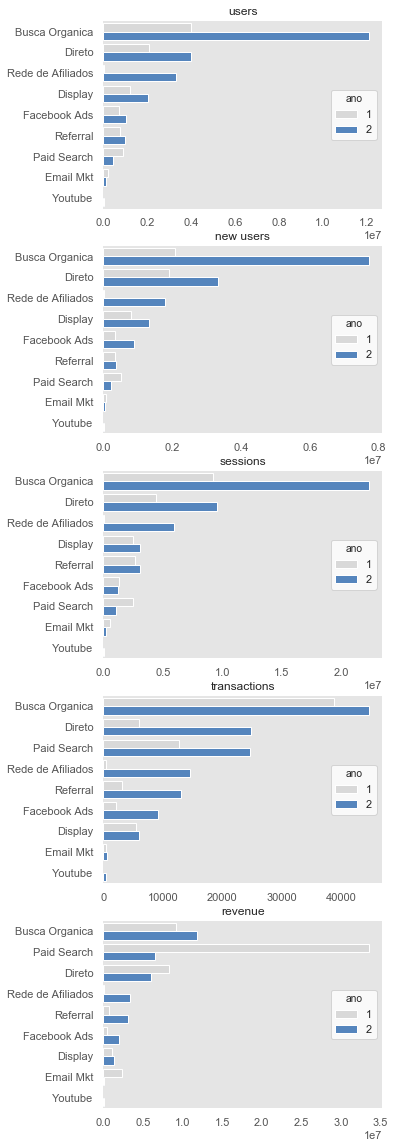

In [136]:
#%matplotlib inline
fig, axs = plt.subplots(nrows=5, figsize=(5,20))
#sns.barplot(x='canal de aquisicao', y='users', hue='ano', data=df3_total.reset_index())
sns.set(style="whitegrid")

for i, c in enumerate(metricas_acum):
    ordem = list(df3_total_ano[ df3_total_ano['ano'] == '2' ].sort_values(by=c, ascending=False)['canal de aquisicao'])
    sns.barplot(x=c, y='canal de aquisicao', hue='ano', order=ordem, data=df3_total_ano, palette=color_palette, ax=axs[i])
    axs[i].set_title(c, fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].grid(False)
    #plt.ticklabel_format(style='plain', axis='x',useOffset=False)

#axs[0].legend(loc="lower right", frameon=True)
#axs[1].set(xlim=(0, 24), ylabel="", xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
plt.show()